## Read in and setup data

We have the option of reading in and setting up data from two different sources:

* Yelp! Restaurant Reviews
* Amazon Magazine Reviews

### Yelp! Restaurant Reviews

Sometimes it's easiest to test everything out with a small amount of data. The tab delimited [Restaurant Reviews Dataset](http://course.ccs.neu.edu/cs6220/fall2023/homework-5/Restaurant_Reviews.tsv) is a common dataset that is used for natural language tasks that predict the sentiment of a given review.

I've provided a helper script (called [cs6220hw5.py](http://course.ccs.neu.edu/cs6220/fall2023/homework-5/cs6220hw5.py)) that splits the data, standardizes the characters, and weeds out stop words, to parse and clean the text up, which should only be run once.

### Amazon Magazine Reviews

[This is the data for the homework](http://jmcauley.ucsd.edu/data/amazon/index_2014.html), which was released in 2014 and is slightly larger and may take some time to setup. We're only using the Magazine Subscriptions.

### Reference
* Jianmo Ni, Jiacheng Li, Julian McAuley, "*Justifying Recommendations using Distantly-Labeled Reviews and
Fine-Grained Aspects*", In Proceedings of **Empirical Methods in Natural Language Processing**, 2019

In [8]:
#@title Setup the Data (RUN ME)

# Which dataset to download?
dataset = 'magazines' # @param ["restaurant", "magazines"]

# Start with a clean slate
!rm -rf *
!wget -nc http://course.ccs.neu.edu/cs6220/fall2023/homework-5/cs6220hw5.py

# Import everything, including homework code
import numpy as np                                              # numpy array
import pandas as pd                                             # data science
import matplotlib.pyplot as plt                                 # matplotlib
import seaborn as sns                                           # plot style
from sklearn.metrics import confusion_matrix                    # confusion matrix
from sklearn.feature_extraction.text import CountVectorizer     # bag of words
from sklearn.model_selection import train_test_split            # train/test split
from sklearn.preprocessing import MinMaxScaler                  # scale data with min/max
from tqdm import tqdm_notebook as tqdm                          # download data utility
import json                                                     # amazon data in json
from IPython.display import clear_output
import cs6220hw5                                                # import cs6220

if dataset == 'restaurant':
  !wget -nc http://course.ccs.neu.edu/cs6220/fall2023/homework-5/Restaurant_Reviews.tsv

  # Read the CSV data
  data = pd.read_csv('Restaurant_Reviews.tsv', delimiter = '\t', quoting = 3)

else:
  # Download from https://cseweb.ucsd.edu/~jmcauley/datasets/amazon_v2/
  !wget -nc https://datarepo.eng.ucsd.edu/mcauley_group/data/amazon_v2/categoryFiles/Magazine_Subscriptions.json.gz
  !gunzip Magazine_Subscriptions.json.gz

  # Load data in
  reviews = []
  with open('Magazine_Subscriptions.json', 'r') as f:
      for l in tqdm(f):
          r = json.loads(l)
          reviews.append(r)

  # Format the data into Pandas DataFrame
  data = pd.DataFrame.from_records(reviews)[['reviewText', 'overall']]
  print("Initial data size: ", data.size)
  data = data[ data['overall'] != 3.0]
  data = data.rename(columns={"reviewText": "Review"})
  data['Liked'] = 0
  data.loc[data['overall'] > 3, 'Liked'] = 1
  data = data.dropna()

clear_output()
print("Data matrix has shape: ", data.shape)
data.head(10)

Data matrix has shape:  (82687, 3)


,Review,overall,Liked
0,"for computer enthusiast, MaxPC is a welcome si...",5.0,1
1,Thank god this is not a Ziff Davis publication...,5.0,1
3,This beautiful magazine is in itself a work of...,5.0,1
4,A great read every issue.,5.0,1
6,I've read Maximum PC (MPC) for many years. The...,5.0,1
7,We ordered this magazine for our grandson (the...,5.0,1
8,I have subscribed to the nook version for a fe...,4.0,1
9,"I'm old, and so is my computer. Any advice th...",4.0,1
10,"At one time, this was my least favorite comput...",5.0,1
11,I didn't receive a full year. I only receive ...,2.0,0


(array([16251.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0., 66436.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

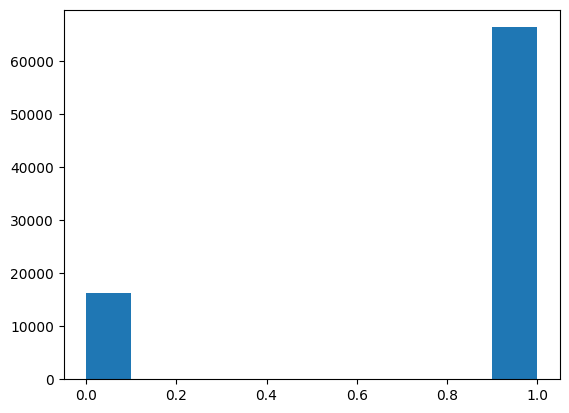

In [9]:
#@title Create a histogram of positive vs negative labels (YOUR CODE HERE)

plt.hist(data['Liked'])

## Preprocess data

Here, you will:

* **Rebalance** the *training data* (leave the test dataset the same).
* **Clean up** the data: remove stopwords, punctuation, verb tense, etc.
* **Assign words** to a "bag of words" where each input feature is a histogram (count) of which words occur in the review.

To clean up the data, I have provided a function in [`cs6220hw5.py`](https://course.ccs.neu.edu/cs6220/fall2023/homework-5/cs6220hw5.py) called `clean_text`. Go ahead and take a look at what it does and explain. This takes a long time to run. What takes the most amount of time? Why?

You will notice in the "bag of words" featurization there are a lot of design decisions.

In [10]:
#@title Create splits & rebalance **training** data (YOUR CODE HERE)

test_size = 0.1 #@param

# <YOUR CODE HERE>

'''
You will need to

1. Split the training and test dataset to be 90 / 10%
2. Rebalance the training dataset so that it's 50/50
   positive / negative
'''
training_num = int(len(data) *  (1 - test_size))

# Split into train/test
training_data = data[:training_num]
testing_data = data[training_num:]

# Rebalance by undersampling the positive reviews
negative_samples = training_data[ training_data['Liked'] ==0]
positive_samples = training_data[ training_data['Liked'] ==1][:len(negative_samples)]

training_data = pd.concat([negative_samples, positive_samples])

In [11]:
#@title Clean text with `cs6220hw5.py`. (RUN ME & get some coffee; it takes a while.)

# The following code takes training data in the same format:
#    Review	| Stars |	Liked
training_corpus, testing_corpus = cs6220hw5.clean_text(training_data, testing_data)

In [12]:
#@title Featurize into Bag of Words (Example Code)

# creating the count vectorizer model with max_features
vocab_size = 200                #@param
test_size = 0.1                 #@param
minmax_scale = True             #@param

cv = CountVectorizer(max_features = vocab_size)
x_train = cv.fit_transform(training_corpus).toarray()
y_train = np.array(training_data['Liked'])

x_test = cv.fit_transform(testing_corpus).toarray()
y_test = np.array(testing_data['Liked'])

if minmax_scale:
  mm = MinMaxScaler()
  x_train = mm.fit_transform(x_train)
  x_test = mm.transform(x_test)

# Run all the algorithms

Play around with some thresholds. Because your evaluation dataset has the original distribution, play with that parameter. For each algorithm, print out:

* Accuracy
* Confusion Matrix
* Precision / Recall AUC

Naive Bayes:
Accuracy: 0.6668279114765994
Precision: 0.8518249500635555
Recall: 0.7075414781297135
[[ 823  816]
 [1939 4691]]

Random Forest:
Accuracy: 0.5487967106058774
Precision: 0.9003037834852251
Recall: 0.4917043740573152
[[1278  361]
 [3370 3260]]

Decision Tree:
Accuracy: 0.50864675293264
Precision: 0.8507789013391637
Recall: 0.46953242835595776
[[1093  546]
 [3517 3113]]

Logisitic Regression:
Accuracy: 0.5954770830813884
Precision: 0.9312155421370438
Recall: 0.5349924585218703
[[1377  262]
 [3083 3547]]



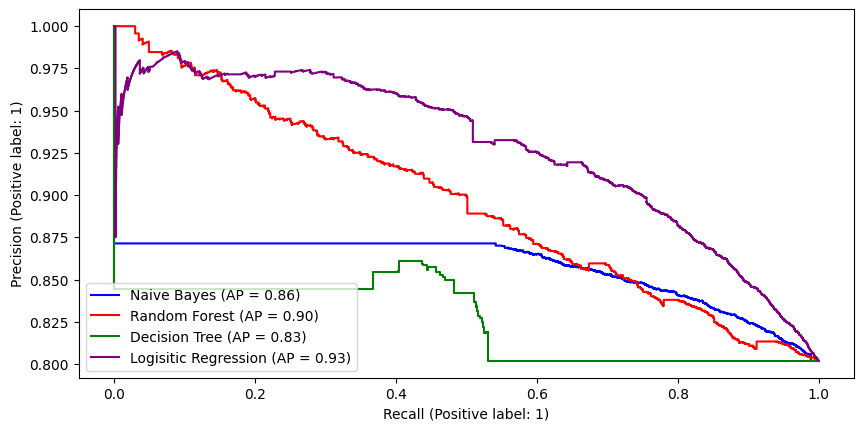

In [13]:
#@title Naive Bayes, Random Forest, Decision Tree Classifier, Logistic Regression (YOUR CODE HERE)

from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, PrecisionRecallDisplay
from matplotlib.gridspec import GridSpec

# YOUR CODE HERE
models = [('Naive Bayes', 'blue', GaussianNB()), 
          ('Random Forest', 'red',  RandomForestClassifier()),
          ('Decision Tree', 'green', DecisionTreeClassifier()),
          ('Logisitic Regression', 'purple', LogisticRegression())]

fig = plt.figure(figsize=(10,10))
gs = GridSpec(4, 2)
pr_auc = fig.add_subplot(gs[:2, :2])
pr_displays = {}

for model_name, color, model in models:
    model.fit(x_train, y_train)
    
    conf_mat = confusion_matrix(y_test, model.predict(x_test))
    tn, fp, fn, tp = conf_mat.ravel()
    
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)

    print(f'{model_name}:')
    print(f'Accuracy: {accuracy}\nPrecision: {precision}\nRecall: {recall}')
    print(f'{conf_mat}\n')

    
    display = PrecisionRecallDisplay.from_estimator(
        model, x_test, y_test, name=model_name, color=color, ax=pr_auc
    )
    pr_displays[model_name] = display


The 4 models metrics are quite similar but there are some noticable differences between the results. The first thing I noticed was that the Accuracy of the Naive Bayes Model was quite high compared to the rest, and it had a much difference between its precision and recall, meaning the model did quite a good job at learning a mapping for the data distribution. In contrast, the Decision Tree model has the lowest accuracy, and has a very low recall score, indicating that it was not good at capturing all of the positives in the data and misclassified many of them.

Based on the PR AUC curves on the test data, we can see that the Decision Tree model and the Naive Bayes model are likely overfitting, since their AUC is the lowest.